# Variant Calling Report
## Input File

In [12]:
import pandas as pd
import h5py
import matplotlib.pyplot as plt
import numpy as np
from configparser import ConfigParser

configFile='var_report.config'
parser = ConfigParser()
parser.read(configFile)

h5FileName_trained = parser.get('VarReport', 'trained_h5_model_file')
h5FileName_const = parser.get('VarReport', 'const_h5_model_file')

model = parser.get('VarReport', 'model')



## Optimal Performance

In [13]:
model=parser.get('VarReport','model')
categories=['SNP','Non-hmer INDEL','HMER indel <= 4','HMER indel > 4, < 12']

optimal=pd.read_hdf(h5FileName_trained, key='optimal_recall_precision', mode='r')
curve=pd.read_hdf(h5FileName_trained, key='recall_precision_curve', mode='r')

optimal=optimal[optimal['model']==model].set_index('category').reindex(categories)
curve=curve[curve['model']==model].set_index('category').reindex(categories)


In [14]:
optimal[['recall','precision']]    

,recall,precision
category,,
SNP,0.981141,0.992870
Non-hmer INDEL,0.829767,0.937008
HMER indel <= 4,0.884501,0.893320
"HMER indel > 4, < 12",0.400000,0.805461


## Performance Plots

Text(0, 0.5, 'Precision')

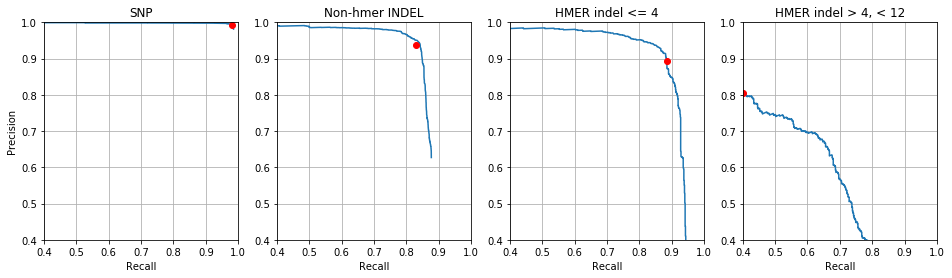

In [15]:
categories=['SNP','Non-hmer INDEL','HMER indel <= 4','HMER indel > 4, < 12']

fig, ax = plt.subplots(1,4,figsize=(16,4))
for i,cat in enumerate(categories):
    recall=curve.loc[cat,'recall']
    precision=curve.loc[cat,'precision']

    recallOpt=optimal.loc[cat,'recall']
    precisionOpt=optimal.loc[cat,'precision']
    
    ax[i].plot(recall,precision,'-',label=cat)    
    ax[i].plot(recallOpt,precisionOpt,'or')    
    ax[i].set_title(cat)
    ax[i].set_xlabel("Recall")
    ax[i].set_xlim([0.40,1])
    ax[i].set_ylim([0.40,1])
    ax[i].grid(True)

ax[0].set_ylabel("Precision")


## Constant model Performance

In [25]:
model=parser.get('VarReport','model')
ix = model.index("recall_precision")
ix += len("recall_precision_")
model = f'untrained_{model[ix:]}'
categories=['SNP','Non-hmer INDEL','HMER indel <= 4','HMER indel > 4, < 12']

optimal=pd.read_hdf(h5FileName_const, key='optimal_recall_precision', mode='r')
curve=pd.read_hdf(h5FileName_const, key='recall_precision_curve', mode='r')


optimal=optimal[optimal['model']==model].set_index('category').reindex(categories)
curve=curve[curve['model']==model].set_index('category').reindex(categories)


In [14]:
optimal[['recall','precision']]    

,recall,precision
category,,
SNP,0.981141,0.992870
Non-hmer INDEL,0.829767,0.937008
HMER indel <= 4,0.884501,0.893320
"HMER indel > 4, < 12",0.400000,0.805461


## Performance Plots

Text(0, 0.5, 'Precision')

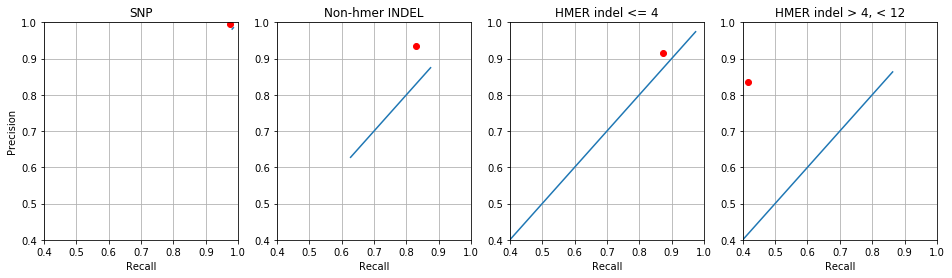

In [26]:
categories=['SNP','Non-hmer INDEL','HMER indel <= 4','HMER indel > 4, < 12']

fig, ax = plt.subplots(1,4,figsize=(16,4))
for i,cat in enumerate(categories):
    recall=curve.loc[cat,'recall']
    precision=curve.loc[cat,'precision']

    recallOpt=optimal.loc[cat,'recall']
    precisionOpt=optimal.loc[cat,'precision']
    
    ax[i].plot(recall,precision,'-',label=cat)    
    ax[i].plot(recallOpt,precisionOpt,'or')    
    ax[i].set_title(cat)
    ax[i].set_xlabel("Recall")
    ax[i].set_xlim([0.40,1])
    ax[i].set_ylim([0.40,1])
    ax[i].grid(True)

ax[0].set_ylabel("Precision")
